Calculating perplexities...
100%|██████████| 13240/13240 [01:10<00:00, 188.34it/s]
Testing models...
100%|██████████| 26/26 [08:19<00:00, 19.19s/it]


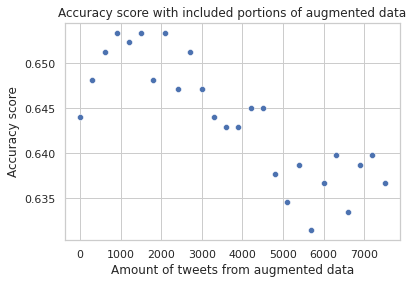

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from nltk.tokenize import TweetTokenizer
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.util import bigrams
from nltk.lm import Lidstone
from pprint import pprint
from tabulate import tabulate
from functions import preprocess, preprocess_tweet
from tqdm import tqdm

with open("tweeteval/datasets/irony/train_text.txt", "r", encoding="utf8") as f:
    irony_train_data = preprocess(f.read().rstrip())
pattern = re.compile(TweetTokenizer().WORD_RE.pattern, flags=re.I|re.VERBOSE|re.UNICODE)
with open("tweeteval/datasets/offensive/train_text.txt", "r", encoding="utf8") as f:
    offensive_train = preprocess(f.read().rstrip())
with open("tweeteval/datasets/offensive/val_text.txt", "r", encoding="utf8") as f:
    offensive_val = preprocess(f.read().rstrip())
offensive = np.concatenate((offensive_train, offensive_val))

irony_tokens = [re.findall(pattern, tweet) for tweet in irony_train_data]
offensive_tokens = [re.findall(pattern, tweet) for tweet in offensive]
_, vocab = padded_everygram_pipeline(2, irony_tokens + offensive_tokens)
train, _ = padded_everygram_pipeline(2, irony_tokens)
lm = Lidstone(0.2, 2)
lm.fit(train, vocab)
perplexities = []
ngrams_linewise = list(bigrams(tweet) for tweet in offensive)
print("Calculating perplexities...")
for tweet in tqdm(ngrams_linewise):
    try:
        perplexity = lm.perplexity(tweet)
        perplexities.append(perplexity)
    except ZeroDivisionError:
        perplexity = math.inf
        perplexities.append(perplexity)
df = pd.DataFrame(data = {"index": [i for i in range(len(perplexities))], "perp": perplexities})
df = df.sort_values(by="perp")
index = df["index"].tolist()
aug_tweets = [preprocess_tweet(offensive[i]) for i in index]

irony_train_labels = np.loadtxt("tweeteval/datasets/irony/train_labels.txt")
with open("tweeteval/datasets/irony/val_text.txt", "r", encoding="utf8") as f:
    irony_val_data = preprocess(f.read().rstrip())
irony_val_labels = np.loadtxt("tweeteval/datasets/irony/val_labels.txt")

classifier = SGDClassifier(max_iter=100000, learning_rate="constant", eta0=0.0001, n_iter_no_change=5000)
clf = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
                        TfidfTransformer(), classifier)
clf.fit(irony_train_data, irony_train_labels)
aug_pred_val = clf.predict(aug_tweets)

n_irony = len(irony_train_labels)
mixed_train_data = np.concatenate([irony_train_data, aug_tweets])
mixed_train_labels = np.concatenate([irony_train_labels, aug_pred_val])

portions = list(range(0, 7501, 300))
acc_scores = np.empty((len(portions)))

print("Testing models...")
for i, portion in tqdm(list(enumerate(portions))):
    x_train = mixed_train_data[:n_irony + portion]
    y_train = mixed_train_labels[:n_irony + portion]

    classifier = SGDClassifier(max_iter=100000, learning_rate="constant", eta0=0.0001, n_iter_no_change=5000)
    clf = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
                        TfidfTransformer(), classifier)
    clf.fit(x_train, y_train);

    y_pred_val = clf.predict(irony_val_data)
    acc_scores[i] = accuracy_score(irony_val_labels, y_pred_val)
sns.set_theme("notebook")
sns.set_style("whitegrid")
fig = sns.scatterplot(x=portions, y=acc_scores)
fig.set_title("Accuracy score with included portions of augmented data")
fig.set_xlabel("Amount of tweets from augmented data")
fig.set_ylabel("Accuracy score")
plt.savefig("figures/aug_data_irony.png", dpi=400, bbox_inches="tight")

Text(0.5, 1.0, '1500 augmented tweets')

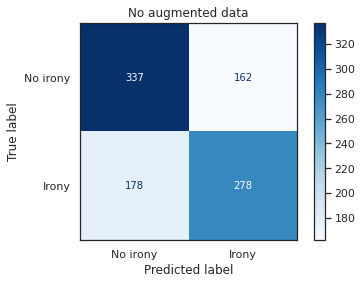

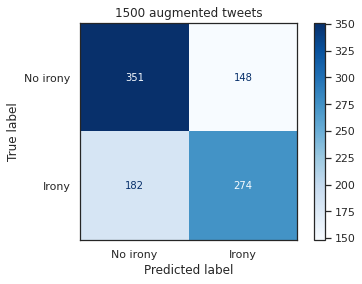

In [6]:
sns.set_style("white")
conf_mat_labels = ["No irony", "Irony"]
classifier = SGDClassifier(max_iter=100000, learning_rate="constant", eta0=0.0001, n_iter_no_change=5000)
clf = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
                    TfidfTransformer(), classifier)
clf.fit(irony_train_data, irony_train_labels)
y_pred_val = clf.predict(irony_val_data)
conf_mat = confusion_matrix(irony_val_labels, y_pred_val)
display = ConfusionMatrixDisplay(conf_mat, display_labels=conf_mat_labels)
fig = display.plot(cmap=plt.cm.Blues)
fig.ax_.set_title("No augmented data")

conf_mat_labels = ["No irony", "Irony"]
classifier = SGDClassifier(max_iter=100000, learning_rate="constant", eta0=0.0001, n_iter_no_change=5000)
clf = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
                    TfidfTransformer(), classifier)
clf.fit(mixed_train_data[:n_irony + 1500], mixed_train_labels[:n_irony + 1500])
y_pred_val = clf.predict(irony_val_data)
conf_mat = confusion_matrix(irony_val_labels, y_pred_val)
display = ConfusionMatrixDisplay(conf_mat, display_labels=conf_mat_labels)
fig = display.plot(cmap=plt.cm.Blues)
fig.ax_.set_title("1500 augmented tweets");

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e4cdc3a5-dd4a-4d72-a71a-972cea883107' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>